In [417]:
import numpy as np
import math
import copy
import pygame
import matplotlib.pyplot as plt
import random
from pygame.locals import *
import os

In [418]:
class PlaceCell():
    """place cell, defined by its center and its sigma"""
    
    def __init__(self, center, sigma):
        """center: 2d array representing coordinates,
        sigma: breadth of place field"""
        self.center = center
        self.sigma = sigma
        self.w = 0 #critic weight
        self.newW = []
        self.zs = np.zeros(8)
        self.newZs = [[] for i in range(8)]
        
    def __str__(self):
        return str(self.center[0])+'-'+str(self.center[1])+" "    
    def __repr__(self):
        return str(self.center[0])+'-'+str(self.center[1])+" "
        
    def activity(self, p):
        """p: agent position"""
        dist = np.linalg.norm(self.center-p)
        res = math.exp(-(dist**2/(2*self.sigma**2)))
        return res
    
def placeCellsGenerator(N, sigma, dist):
    """returns an x by y python list of place cells separated by a distance dist"""
    pCArray = np.full([N,N], None)
    for i in range(N):
        for j in range(N):
            center = np.array([i*dist, j*dist])
            pC = PlaceCell(center, sigma)
            pCArray[i,j] = pC
    return pCArray

pCArrayActivity = np.vectorize(lambda pC: pC.activity(p))

In [419]:
class Critic():
    """critic, defined by an array of place cells associated with weights"""
    
    def __init__(self, pCArray):
        """place cells passed as argument, all weights initialized to 1"""
        N = len(pCArray)
        r = np.full([N*3, N*3], None)
        r[:N, :N] = r[N*2:, :N] = r[:N, N*2:] = r[N*2:, N*2:] = np.flip(pCArray, (0, 1))
        r[:N, N:N*2] = r[N*2:, N:N*2] = np.flip(pCArray, 0)
        r[N:N*2, :N] = r[N:N*2, N*2:] = np.flip(pCArray, 1)
        r[N:N*2, N:N*2] = pCArray
        self.pCArray = r
        
    def activity(self, p):
        actFun = np.vectorize(lambda pC: pC.activity(p)*pC.w)
        pCact = actFun(self.pCArray)
        return np.sum(pCact)

In [420]:
class Actor():
    def __init__(self, index, pCArray, direction):
        """index: index in PlaceCell actW, pCarray: array of PlaceCells"""
        self.index = index
        self.pCArray = pCArray
        self.direction = direction
        
    def activity(self, p):
        actFun = np.vectorize(lambda pC: pC.activity(p)*pC.zs[self.index])
        pCact = actFun(self.pCArray)
        return np.sum(pCact)
    
class ActorSet():
    def __init__(self, pCArray):
        directions = [np.array([i,j]) for i in (-1,0,1) for j in (-1,0,1) if (i,j)!=(0,0)]
        self.acts = np.full(8, None)
        for i in range(8):
            self.acts[i] = Actor(i, pCArray, directions[i])
            
    def prob(self, p):
        actFun = np.vectorize(lambda a: a.activity(p))
        aAct = np.exp(2*actFun(self.acts))
        sumA = np.sum(aAct)
        return aAct/sumA
    
    def pickActor(self, pos):
        c = 0
        r = random.random()
        prob = self.prob(pos)
        for i in range(len(self.prob(pos))):
            c += prob[i]
            if r<c:
                return self.acts[i]

In [421]:
def extract(alt, ws):
    sumW = sum(ws)
    if sumW == 0:
        return random.sample(alt, 1)[0]
    wsNorm = [w/sumW for w in ws]
    i = 0
    intvs = []
    for w in wsNorm:
        intvs.append(i+w)
        i += w
                   
    r = random.random()
    for i in range(len(wsNorm)):
        if r<intvs[i]:
            return alt[i]

class Agent():
    def __init__(self, pos):
        self.pos = pos
        self.posHist = []
        
    def move(self, critic, actorSet, maxD):
        p = self.pos
        a = actorSet.pickActor(self.pos)
        nextPos = self.pos+a.direction
        while any(nextPos>=maxD) or any(nextPos<0):
            a = actorSet.pickActor(self.pos)
            nextPos = self.pos+a.direction
        self.pos = nextPos
        if self.posHist:
            self.posHist[-1][1] = a.index 
        self.posHist.append([nextPos, -1])
        return nextPos

In [422]:
def changeW(pC, dw):
    pC.newW.append(pC.w+dw)
    
changeWVect = np.vectorize(changeW)

def changeZ(pC, dz, index):
    pC.newZs[index].append(pC.zs[index]+dz)
    
changeZVect = np.vectorize(changeZ)

def updateW(pCArray, delta, pos, epsilonW):
    f = np.vectorize(lambda pC: pC.activity(pos))
    dw = epsilonW*delta*f(pCArray)
    changeWVect(pCArray, dw)
    
def updateZ(pCArray, delta, pos, index, epsilonZ):
    f = np.vectorize(lambda pC: pC.activity(pos))
    actpCArray = np.vectorize(lambda pC: pC.activity(pos))
    dz = epsilonZ*delta*f(pCArray)
    changeZVect(pCArray, dz, index)
    
def flip(pC):
    pC.w = np.average(np.array(pC.newW))
    pC.zs = np.array([np.average(np.array(l)) for l in pC.newZs])
    
flipVect = np.vectorize(flip)

def updateAllWeights(pCArray, critics, posHist, gamma, epsilonW, epsilonZ):
    updated = {}
    for i in range(len(posHist)):
        p, ind = posHist[-(i+1)] #position
        x, y = p[0], p[1]
        if (x,y) not in updated:
            #posHist[-i] : next position; when p_gamma = 0, gamma**p_gamma = 1 = R_t
            nextP = posHist[-i][0]
            x2, y2 = nextP[0], nextP[1]
            if i>0:
                p_gamma = updated[(x2, y2)]+1
            else:
                p_gamma = 0
            updated[(x,y)] = p_gamma
            delta = gamma**p_gamma - critics.activity(p)
            updateW(pCArray, delta, p, epsilonW)
            if ind>=0 : #when pos == platform's pos, ind = -1
                updateZ(pCArray, delta, p, ind, epsilonZ)
            
    N = len(pCArray)
    c = np.full([N,N], 0.)
    for i,j in list(updated.keys()):
        p = np.array([i,j])
        c[i, j] = gamma**updated[(i, j)] - critics.activity(p)
        
    flipVect(pCArray)
    return c

In [423]:
def draw(mat, col, size, title, axes = True):
    N = len(mat)
    maxV = np.amax(mat)
    minV = np.amin(mat)
    normMat = (mat-minV)/(maxV-minV)
    colMat = np.array([[[k*normMat[i,j] for k in col]+[1] for j in range(N)] for i in range(N)])
    fig, ax = plt.subplots(figsize=size)
    if not axes:
        ax.set_xticks([])
        ax.set_yticks([])
    ax.imshow(colMat)
    plt.gca().invert_yaxis()
    plt.savefig('graphs/%s.png' % title)
    plt.show()
    
def drawSyst(pAg, pPf, N, size, title,axes = True):
    fig, ax = plt.subplots(figsize=size)
    colMat = np.array([[[0., 0., 125/255, 1.] for i in range(N)] for j in range(N)])
    a, b = pAg[0], pAg[1]
    c, d = pPf[0], pPf[1]
    colMat[a,b,:] = np.array([200, 200, 200, 255])/255
    colMat[c,d,:] = np.array([200, 50, 50, 255])/255
    if not axes:
        ax.set_xticks([])
        ax.set_yticks([])
    ax.imshow(colMat)
    plt.gca().invert_yaxis()
    plt.savefig('graphs/%s.png' % title)
    plt.show()

In [424]:
def getInd(pC):
    mx = 0
    for i in range(8):
        if pC.zs[i]>pC.zs[mx]:
            mx = i
    return mx

getIndVect = np.vectorize(getInd)

getZs = np.vectorize(lambda pC, ind: pC.zs[ind])

def drawDirection(pCArray, actorSet, size, title):
    N = len(pCArray)
    U = np.zeros([N, N])
    V = np.zeros([N, N])
    inds = getIndVect(pCArray)
    zs = getZs(pCArray, inds)
    getVect = lambda ind, z: actorSet.acts[ind].direction*z
    for i in range(N):
        for j in range(N):
            Vect = getVect(inds[i,j], zs[i,j])
            U[i,j], V[i,j] = Vect[0], Vect[1]
            

    fig, ax = plt.subplots(figsize = size)
    q = ax.quiver(np.arange(N), np.arange(N), U, V)
    #ax.quiverkey(q, X=0.3, Y=1.1, U=10, labelpos='E')

    plt.show()

In [425]:
def main2():
    if not os.path.exists("graphs/"):
        os.makedirs("graphs/")
        
    #constants
    N = 10
    sigma = 0.5 #place cell's sigma
    dist = 1 #distance between place cells
    gamma = 0.97
    epsilonW = 0.1
    epsilonZ = 0.1
    
    pCArray = placeCellsGenerator(N, sigma, dist)
    crit = Critic(pCArray)
    actSet = ActorSet(pCArray)
    
    #print(c)
    
    rat = Agent(np.array([random.randint(0,N-1), random.randint(0, N-1)]))
    platformPos = np.array([random.randint(0,N-1), random.randint(0, N-1)])
    while all(rat.pos==platformPos):
        rat.pos = np.array([random.randint(0,N-1), random.randint(0, N-1)])
    px, py = platformPos
    
    nbTrials = 30
    nbSimulations = 25
    Xs = np.zeros([nbSimulations, nbTrials])

    for t in range(nbSimulations):
        tick = 0
        iterations = 0
        print(t, end =": ")
        while iterations<nbTrials and tick<50000:
            if any(rat.pos!=platformPos):
                rp = rat.move(crit, actSet, N)
            else:
                Xs[t, iterations] = len(rat.posHist)
                while all(rat.pos==platformPos):
                    rat.pos = np.array([random.randint(0,N-1), random.randint(0, N-1)])

                dw = updateAllWeights(pCArray, crit, rat.posHist, gamma, epsilonW, epsilonZ)
                rat.posHist = []
                iterations += 1
                print(iterations, end="-")
            tick += 1
        if tick>=50000:
            print("FAIL")
            break
        print()
            
    plt.figure()
    #plt.plot(range(nbTrials), np.average(Xs, axis=0))
    plt.errorbar(range(nbTrials), np.average(Xs, axis=0), yerr=np.std(Xs, axis=0))
    plt.show()

In [426]:
def main():
    if not os.path.exists("graphs/"):
        os.makedirs("graphs/")
    
    #constants
    N = 10
    sigma = 0.6 #place cell's sigma
    dist = 1 #distance between place cells
    gamma = 0.97
    epsilonW = 0.5
    epsilonZ = 0.1
    
    np.set_printoptions(precision=3)
    np.set_printoptions(suppress=True)
    
    pCArray = placeCellsGenerator(N, sigma, dist)
    crit = Critic(pCArray)
    actSet = ActorSet(pCArray)
    
    #Example of placecells for p = (5,5)
    #ref = np.array([5,5])
    #actFC = np.vectorize(lambda pC : pC.activity(ref))
    #ACT = actFC(pCArray)
    #draw(ACT, [1, 1, 0], (7,7), "placeCell", axes = False)
    
    #print(c)
    
    rat = Agent(np.array([random.randint(0,N-1), random.randint(0, N-1)]))
    platformPos = np.array([random.randint(0,N-1), random.randint(0, N-1)])
    while all(rat.pos==platformPos):
        rat.pos = np.array([random.randint(0,N-1), random.randint(0, N-1)])
    px, py = platformPos
    
    #plot of the initial configuration
    drawSyst(rat.pos, platformPos, N, (7,7), "system")
    
    #graphic constants
    px_size = 25
    bckCol = (0, 0, 125)
    pfCol = (200, 50, 50)
    
    #pygame 
    pygame.init()
    screen = pygame.display.set_mode((px_size*N, px_size*N), pygame.DOUBLEBUF)
    screen.fill(bckCol)
    bckGrnd = [[bckCol for i in range(N)] for j in range(N)]
    bckGrnd[px][py] = pfCol
    pygame.draw.rect(screen, pfCol, (px*px_size, py*px_size, px_size, px_size))
    # wait till the window is closed
    clock = pygame.time.Clock()
    done = False
    tick = 0
    iterations = 0
    while not done:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                done = True
                
            if event.type == KEYDOWN and event.key == K_c and all(rat.pos==platformPos):
                x, y = platformPos
                pygame.draw.rect(screen, pfCol, (x*px_size, y*px_size, px_size, px_size))
                while all(rat.pos==platformPos):
                    rat.pos = np.array([random.randint(0,N-1), random.randint(0, N-1)])   
                
                
        tick += 1
        if any(rat.pos!=platformPos):
            i, j = rat.pos
            pygame.draw.rect(screen, bckGrnd[i][j], (i*px_size, j*px_size, px_size, px_size))
            rp = rat.move(crit, actSet, N)
            i, j = rp[0], rp[1]
            pygame.draw.rect(screen, (200, 200, 200), (i*px_size, j*px_size, px_size, px_size))
        elif iterations<61:
            x, y = platformPos
            pygame.draw.rect(screen, pfCol, (x*px_size, y*px_size, px_size, px_size))
            while all(rat.pos==platformPos):
                rat.pos = np.array([random.randint(0,N-1), random.randint(0, N-1)])
                
            dw = updateAllWeights(pCArray, crit, rat.posHist, gamma, epsilonW, epsilonZ)
            rat.posHist = []
            if iterations == 0:
                draw(dw, [0., 0., 1.], (5,5), "dW_0")
            
            if iterations == 60:
                c = [[crit.activity(np.array([i,j])) for j in range(N)] for i in range(N)]
                c = np.array(c)
                draw(c, [1., 0., 0.5], (5,5), "crit_"+str(iterations))

                drawDirection(pCArray, actSet, (5,5), "dir_"+str(iterations))
            
            iterations += 1

        # display the backbuffer
        pygame.display.flip()
        clock.tick(50)
    pygame.display.quit()
    pygame.quit()

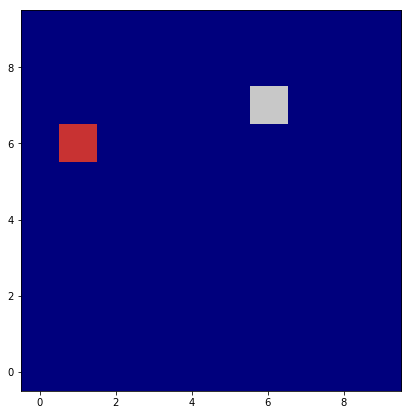

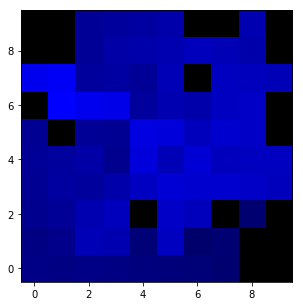

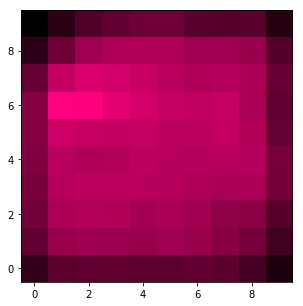

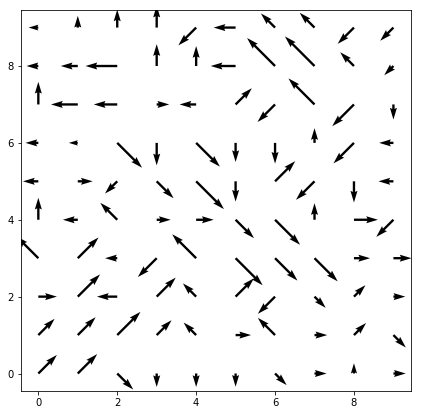

In [428]:
if __name__ == '__main__':
    main()
    #main2

In [ ]:
def getInd(pC):
    mx = 0
    for i in range(8):
        if pC.zs[i]>pC.zs[mx]:
            mx = i
    return mx

getIndVect = np.vectorize(getInd)

def drawDirection2(pCArray, actorSet, size, title):
    U = np.zeros([N, N])
    V = np.zeros([N, N])
    pCArray, actSet
    inds = getIndVect(pCArray)
    getVect = lambda ind: actorSet.acts[ind].direction*pCArray.zs[ind]
    for i in range(N):
        for j in range(N):
            Vect = getVect(inds[i,j])
            U[i,j], V[i,j] = Vect[0], Vect[1]
            

    fig, ax = plt.subplots(figsize = (5, 5))
    q = ax.quiver(np.arange(N), np.arange(N), U, V)
    ax.quiverkey(q, X=0.3, Y=1.1, U=10,, labelpos='E')

    plt.show()